<a href="https://colab.research.google.com/github/haizznaam/Thesis-Ecommerce-Price-Prediction/blob/main/3.%20Modelling/4_baseline_mlp(colab).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Basic Libs..
import warnings
warnings.filterwarnings("ignore")
import math
import time
import pandas as pd
import numpy as np
import scipy
import scipy.sparse
from tqdm import tqdm,tqdm_notebook
from prettytable import PrettyTable
import pickle
from IPython.display import Image
from contextlib import contextmanager
import os
print('CWD is ',os.getcwd())

# Vis Libs..
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Text Libs..
import re
from gensim import corpora, models
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer,PorterStemmer
from nltk.stem.porter import *
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer

# ML Libs...
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder,FunctionTransformer
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
from sklearn.feature_selection import SelectKBest,f_regression
from sklearn.model_selection import GridSearchCV


# DL Libs..
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input , Dropout, Flatten,concatenate,LSTM
from tensorflow.keras.layers import Embedding
import tensorflow.keras
from tensorflow.keras.models import Model,load_model
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint,TensorBoard,ReduceLROnPlateau, EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras import optimizers

# Colab Libs...
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

CWD is  /content


# 12. Baseline MLP (Colab)

## 12.1. Setup Colabb Environment

'''
Code below sets up Google Colab to load the input files from
Google Drive and can output files as well
'''

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import os
os.chdir('/content/gdrive/MyDrive/Mercari Price Prediction')
print("We are currently in the folder of ", os.getcwd())

We are currently in the folder of  /content/gdrive/MyDrive/Mercari Price Prediction


## 12.2 Load Data From GDrive

In [ ]:
# /content/gdrive/MyDrive/Mercari Price Prediction
file = open('/content/gdrive/MyDrive/Mercari Price Prediction/2. Processing/storage/df_train_model', 'rb')
df_train_model = pickle.load(file)
file.close()

file = open('/content/gdrive/MyDrive/Mercari Price Prediction/2. Processing/storage/df_test_model', 'rb')
df_test_model = pickle.load(file)
file.close()

print(df_train_model.shape,'\n',df_test_model.shape)

(1111901, 8) 
 (370634, 8)


## 12.3. Encoding data

In [ ]:
'''
This Function concatenates text features from item-name,brand,category,description to create
the concatenated text feature.
'''

def data_preprocess(df):
    df['name'] = df['name'].fillna('') + ' ' + df['brand_name'].fillna('')
    df['text'] = (df['item_description'].fillna('') + ' ' + df['name'] + ' ' + df['category_name'].fillna(''))
    return df[['name', 'text', 'shipping', 'item_condition_id','price']]

In [ ]:
'''
This Function takes in train,test datasets as input and returns
feature transforms - Tfidfvectorizer,Onehotencoder,etc. and
returns concatenated feature (hstack) of X_train,X_test,y_train,y_test as output.
'''
def data_encoder(train,test):
    # Text Encoding for Names...
    vect_name = TfidfVectorizer(max_features=100000, token_pattern='\w+', dtype=np.float32)
    train_name  = vect_name.fit_transform(train['name'].values)
    test_name = vect_name.transform(test['name'].values)

    # Text Encoding for Text...
    vect_text = TfidfVectorizer(max_features=100000, token_pattern='\w+', ngram_range=(1, 2), dtype=np.float32)
    train_text  = vect_text.fit_transform(train['text'].values)
    test_text = vect_text.transform(test['text'].values)

    # Encoding for Shipping, Item Condition ID...
    train_dummies = scipy.sparse.csr_matrix(pd.get_dummies(train[["item_condition_id", "shipping"]], sparse = True).values)
    test_dummies = scipy.sparse.csr_matrix(pd.get_dummies(test[["item_condition_id", "shipping"]], sparse = True).values)

    # Final Feature Stack for X_train,X_test
    X_train = scipy.sparse.hstack((train_name, train_text, train_dummies)).tocsr().astype('float32')
    X_test = scipy.sparse.hstack((test_name, test_text, test_dummies)).tocsr().astype('float32')

    # Final Outputs.. y_train,y_test (Standardizing the output variable price) using standardscaler...
    global y_scaler
    y_scaler = StandardScaler()
    y_train = y_scaler.fit_transform(np.log1p(train['price'].values.reshape(-1, 1)))
    y_test = y_scaler.transform(np.log1p(test['price'].values.reshape(-1, 1)))

    return X_train,X_test,y_train,y_test

In [ ]:
X_train,X_test,y_train,y_test = data_encoder(data_preprocess(df_train_model),data_preprocess(df_test_model))
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(1111901, 190491) (370634, 190491) (1111901, 1) (370634, 1)


## 12.4. Creating MLP Model

In [ ]:
'''Building a Sparse MLP model'''

def build_mlp_model(train):
    model_in = Input(shape=(train.shape[1],), dtype='float32', sparse=True)
    out = Dense(256, activation='relu')(model_in)
    out = Dense(64, activation='relu')(out)
    out = Dense(64, activation='relu')(out)
    out = Dense(32, activation='relu')(out)
    out = Dense(1)(out)
    model = Model(model_in, out)
    return model

In [ ]:
'''Summarizing the model built'''

baseline_mlp_model = build_mlp_model(X_train)
baseline_mlp_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 190491)]          0         
                                                                 
 dense (Dense)               (None, 256)               48765952  
                                                                 
 dense_1 (Dense)             (None, 64)                16448     
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 32)                2080      
                                                                 
 dense_4 (Dense)             (None, 1)                 33        
                                                                 
Total params: 48788673 (186.11 MB)
Trainable params: 48788673

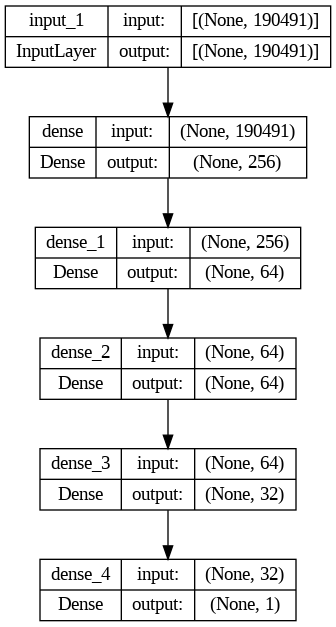

In [ ]:
'''Graphical Visualization of the Model'''

plot_model(baseline_mlp_model, to_file='baseline_mlp_model.png', show_shapes=True, show_layer_names=True)
Image(filename='baseline_mlp_model.png')

## 12.5. Train Model

In [ ]:
'''This function builds a timer which prints time elapsed for a code section to execute'''

@contextmanager
def timer(name):
    t0 = time.time()
    yield
    print(f'[{name}] done in {time.time() - t0:.0f} s')

In [ ]:
'''Defining the Evaluation Metric - RMSLE'''

def rmsle_score(y, y_pred):
    assert len(y) == len(y_pred)
    to_sum = [(math.log(y_pred[i] + 1) - math.log(y[i] + 1)) ** 2.0 for i,pred in enumerate(y_pred)]
    return (sum(to_sum) * (1.0/len(y))) ** 0.5

In [ ]:
'''Training Model'''

baseline_mlp_model.compile(loss='mean_squared_error', optimizer=optimizers.Adam(lr=3e-3))
filepath = "baseline_mlp_model_epochs:{epoch:03d}-val_loss:{val_loss:.3f}.hdf5"
checkpoint = ModelCheckpoint(filepath,monitor="val_loss",mode="min",save_best_only = True,verbose = 1)
tensorboard = TensorBoard(log_dir='/content/gdrive/MyDrive/Mercari Price Prediction/mlp_model')
callbacks_list = [checkpoint,tensorboard]

# Training 3 Models with incremental Batch Sizes of (256,512,1024,2049) for 1 epoch each..
for i in range(5):
    with timer(f'epoch {i + 1}'):
        baseline_mlp_model.fit(x=X_train, y=y_train, batch_size=2**(8 + i), epochs=1, verbose=1, validation_data=(X_test, y_test),callbacks = callbacks_list)
        # print('Test RMSLE after epoch = ',i,' is ',rmsle_score(np.expm1(y_test) , np.expm1(baseline_mlp_model.predict(X_test)[:, 0])),'\n')

        preds = baseline_mlp_model.predict(X_test)[:, 0]
        y_pred = np.expm1(y_scaler.inverse_transform(preds.reshape(-1, 1))[:, 0])
        print('Test RMSLE for batch size = ',2**(8 + i),' is ',rmsle_score(df_test_model.price.values , y_pred),'\n')

4344/4344 [==============================] - ETA: 0s - loss: 0.3625
Epoch 1: val_loss improved from inf to 0.31963, saving model to baseline_mlp_model_epochs:001-val_loss:0.320.hdf5
11583/11583 [==============================] - 26s 2ms/step
Test RMSLE for batch size =  256  is  0.42343225664955736 

[epoch 1] done in 2944 s
2172/2172 [==============================] - ETA: 0s - loss: 0.2198
Epoch 1: val_loss improved from 0.31963 to 0.30813, saving model to baseline_mlp_model_epochs:001-val_loss:0.308.hdf5
11583/11583 [==============================] - 26s 2ms/step
Test RMSLE for batch size =  512  is  0.415742565926576 

[epoch 2] done in 1442 s
1086/1086 [==============================] - ETA: 0s - loss: 0.1246
Epoch 1: val_loss did not improve from 0.30813
11583/11583 [==============================] - 26s 2ms/step
Test RMSLE for batch size =  1024  is  0.4209041642726431 

[epoch 3] done in 754 s
543/543 [==============================] - ETA: 0s - loss: 0.0685
Epoch 1: val_loss d

**Results - Model with batch size = 512 gave the best results**

## 12.6. Test Model

In [ ]:
best_model = load_model('/content/gdrive/MyDrive/Mercari Price Prediction/baseline_mlp_model_epochs:001-val_loss:0.308.hdf5')

preds = best_model.predict(X_test)[:, 0]
y_pred = np.expm1(y_scaler.inverse_transform(preds.reshape(-1, 1))[:, 0])

print('RMSLE of Test set is ',rmsle_score(df_test_model.price.values , y_pred))

11583/11583 [==============================] - 25s 2ms/step
RMSLE of Test set is  0.415742565926576




---


**Summary - We obtain a Test RMSLE of 0.4157, the best Model so far obtained**